In [1]:
%%time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
import io

TensorFlow 1.x selected.
CPU times: user 1.41 s, sys: 312 ms, total: 1.72 s
Wall time: 4.15 s


In [13]:
print(tf.__version__)
print(tf.test.is_gpu_available())
# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# clear calculation graph
tf.reset_default_graph()

1.15.2
False


In [5]:
from google.colab import files
uploaded = files.upload()

Saving test set.csv to test set.csv
Saving training set.csv to training set.csv


In [6]:

training_set = pd.read_csv(io.BytesIO(uploaded['training set.csv'])).iloc[:20000,1:] 

training_X = training_set.loc[:,training_set.columns!='heston_price']

training_Y = training_set['heston_price']
training_X, training_Y = training_X.values,training_Y.values


test_set = pd.read_csv(io.BytesIO(uploaded['test set.csv'])).iloc[:,1:] 
test_X = test_set.loc[:,test_set.columns!='heston_price']
test_Y = test_set['heston_price']

test_X, test_Y = test_X.values,test_Y.values

print(training_X.shape,training_Y.shape,test_X.shape,test_Y.shape)

#normalize
meanX = np.mean(training_X,axis=0)
stdX = np.std(training_X,axis=0)
meanY = np.mean(training_Y,axis=0)
stdY = np.std(training_Y,axis=0)

normX = (training_X - meanX) / stdX
normY = (training_Y - meanY) / stdY
#print(meanX,stdX)
dim = normX.shape[1]
#print(dim,type(meanX))

(20000, 9) (20000,) (100000, 9) (100000,)


In [0]:
# inference = sequence of feed-forward equations from input to output 
# TensorFlow provides higher level function for all kinds of standard layers
# for vanilla layers, the function is tf.layers.dense() 

# the weights and biases are encapsulated and do not explicitly appear in the code

# the argument kernel_initializer allows to control the initialization of the weights
# (the biases are all initialized to 0)
# tf.variance_scaling_initializer() implements the Xavier-He initialization
# (centred Gaussian with variance 1.0 / num_inputs)
# widely considered an effective default, see e.g. Andrew Ng's DL spec on Coursera

def inference(xs):
    
    # hidden layers, note that the weights and biases are encpasulated in the tf functions
    a1 = tf.layers.dense(xs, 5, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a2 = tf.layers.dense(a1, 3, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a3 = tf.layers.dense(a2, 5, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a4 = tf.layers.dense(a3, 2, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a5 = tf.layers.dense(a4, 2, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    # output payer
    ys = tf.layers.dense(a5, 1, activation = None, kernel_initializer = tf.variance_scaling_initializer)
    
    return ys


# calculation graph for prediction and loss

# the instructions below don't calculate anything, they initialize a calculation graph in TensorFlow's memory space
# when the graph is complete, we can run it in a TensorFlow session, on CPU or GPU

# since TensorFlow knows the calculation graph, it will not only evaluate the results, but also the gradients, 
# very effectively, with the back-propagation equations

# reserve space for inputs and labels
inputs = tf.compat.v1.placeholder(shape=[None,dim], dtype = tf.float32)
labels = tf.compat.v1.placeholder(shape=[None,1], dtype = tf.float32)

# calculation graphs for predictions given inputs and loss (= mean square error) given labels
predictions = inference(inputs)
loss = tf.losses.mean_squared_error(labels, predictions)


# definition of the optimizer
# the optimizer computes the gradient of loss to all weights and biases,
# and modifies them all by a small step (learning rate) in the direction opposite to the gradient
# in order to progressively decrease the loss and identify the set of weights that minimize it

learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate) # optimizer obejct
optimize = optimizer.minimize(loss) #  this op now computes gradient and moves weights
# the op 'optimize' performs one iteration of gradient descent

# we can display predictions before, during and after training
# to do this, we execute the inference result named 'predictions' on the session
# with some arbitrary inputs xs
def predict(xs, sess):
    # first, normalize
    nxs = (xs - meanX) / stdX
    # forward feed through ANN
    nys = sess.run(predictions,feed_dict={inputs:nxs})
    # de-normalize output
    ys = meanY + stdY * nys
    # we get a matrix of shape [size of xs][1], which we reshape as vector [size of xs]
    return np.reshape(ys, [-1])


# training set
feed_dict = {inputs:normX, labels:normY[:,np.newaxis]}


# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# we save results after each epoch for visualization
yAxes = [predict(test_X, sess)] 
losses = [sess.run(loss, feed_dict=feed_dict)]
pltepoche = []
#print(test_X.shape,meanX.shape,stdX.shape)

In [10]:
# go
# run the optimizer a few times (called epochs)
epochs = 200000

epo = 0
MAE_test =10.
while epo<epochs and MAE_test>0.01:
    for e in range(1000):
        _, l = sess.run([optimize, loss], feed_dict=feed_dict)
    #yAxes.append(predict(test_X, sess))
    epo += 1000
    losses.append(l)
    pltepoche.append(epo)

#print(len(losses),losses[:5])
#plt.scatter(test_Y,yAxes[-1])
    #MSE_train = round(np.sqrt(sum((training_Y-predict(training_X,sess))**2)/training_Y.shape[0]),4)
    AAE_train = round(sum(abs(training_Y-predict(training_X,sess)))/training_Y.shape[0],4)
    MAE_train = round(max(abs(training_Y-predict(training_X,sess))),4)

    #MAER_train = round(sum(abs(training_Y-predict(training_X,sess))/training_Y)/training_Y.shape[0],4)

    #MSE_test = round(np.sqrt(sum((test_Y-predict(test_X,sess))**2)/test_Y.shape[0]),4)
    AAE_test = round(sum(abs(test_Y-predict(test_X,sess)))/test_Y.shape[0],4)
    MAE_test = round(max(abs(test_Y-predict(test_X,sess))),4)
    #MAER_test = round(sum(abs(test_Y-predict(test_X,sess))/test_Y)/test_Y.shape[0],4)


    #print('MAE_train:{},MAER_train:{},MAE_test:{},MAER_test:{}'.format(MAE_train,MAER_train,MAE_test,MAER_test))
    print('AAE_train:{},MAE_train:{},AAE_test:{},MAE_test:{}'.format(AAE_train,MAE_train,AAE_test,MAE_test))


AAE_train:0.5694,MAE_train:2.7615,AAE_test:0.5658,MAE_test:3.1722
AAE_train:0.5442,MAE_train:2.6656,AAE_test:0.541,MAE_test:3.0344
AAE_train:0.5178,MAE_train:2.5524,AAE_test:0.5151,MAE_test:2.8888
AAE_train:0.491,MAE_train:2.4265,AAE_test:0.4888,MAE_test:2.7378
AAE_train:0.4647,MAE_train:2.2906,AAE_test:0.4627,MAE_test:2.5815
AAE_train:0.4394,MAE_train:2.1587,AAE_test:0.4375,MAE_test:2.4203
AAE_train:0.4159,MAE_train:2.0269,AAE_test:0.4139,MAE_test:2.2576
AAE_train:0.3952,MAE_train:1.8958,AAE_test:0.3929,MAE_test:2.0985
AAE_train:0.3777,MAE_train:1.7715,AAE_test:0.3751,MAE_test:1.9505
AAE_train:0.3634,MAE_train:1.6589,AAE_test:0.3605,MAE_test:1.8198
AAE_train:0.3518,MAE_train:1.5612,AAE_test:0.3487,MAE_test:1.7105
AAE_train:0.3419,MAE_train:1.5232,AAE_test:0.3387,MAE_test:1.6685
AAE_train:0.3334,MAE_train:1.5012,AAE_test:0.3302,MAE_test:1.659
AAE_train:0.3255,MAE_train:1.4763,AAE_test:0.3223,MAE_test:1.6432
AAE_train:0.3184,MAE_train:1.4493,AAE_test:0.3152,MAE_test:1.6225
AAE_train:0.3

KeyboardInterrupt: ignored

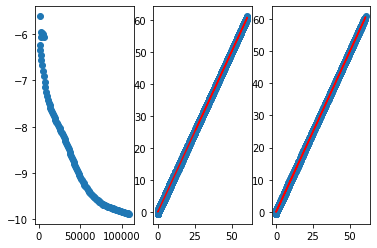

In [11]:
plt.subplot(1,3,1)
plt.scatter(pltepoche,np.log(losses[1:]))

plt.subplot(1,3,2)
plt.scatter(test_Y,predict(test_X,sess))
plt.plot(test_Y,test_Y,c='r')

plt.subplot(1,3,3)
plt.scatter(training_Y,predict(training_X,sess))
plt.plot(training_Y,training_Y,c='r')

plt.show()